In [ ]:
# Step 1: Import Necessary Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import re

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# --- Constants and Configuration ---
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
EPOCHS = 2


In [ ]:
.# Step 2a: Create the classes for the images based on the folder names with different conditions in each folder

# Set path for the director of the data set to be used
DATA_DIR = '/Users/aresbandebo/PycharmProjects/Eye_CNN_Testing/Dataset_Eye_Diseases_Classification/'

# Set the desired image dimensions for resizing.
IMG_HEIGHT = 224
IMG_WIDTH = 224


def create_classes_from_dirs(target_path):
    """
    Scans a target path and dynamically creates Python classes based on the names
    of the directories found within it.

    Args:
        target_path (str): The absolute or relative path to the directory to scan.

    Returns:
        dict: A dictionary containing the names and class objects that were created.
              Returns an empty dictionary if the path does not exist or contains no directories.
    """
    print(f"Attempting to scan for directories in: '{target_path}'")

    # --- 1. Validate the path ---
    if not os.path.isdir(target_path):
        print(f"\nError: The specified path does not exist or is not a directory.")
        print("Please make sure the path is correct and accessible.")
        return {}

    created_classes = {}

    # --- 2. Find all sub-directories ---
    try:
        # Get a list of all entries in the target_path and filter for directories
        dir_names = [name for name in os.listdir(target_path)
                     if os.path.isdir(os.path.join(target_path, name))]
    except OSError as e:
        print(f"\nError: Could not access the path. Reason: {e}")
        return {}

    if not dir_names:
        print("\nNo sub-directories were found in the specified path.")
        return {}

    print(f"\nFound {len(dir_names)} directories. Creating corresponding classes...")

    # --- 3. Create a class for each directory ---
    for dir_name in dir_names:
        # Sanitize the directory name to make it a valid Python class name
        # (e.g., "diabetic retinopathy" -> "Diabetic_retinopathy")
        class_name = re.sub(r'[^0-9a-zA-Z_]', '_', dir_name).capitalize()

        # If the first character is not a letter, prepend 'C' for 'Class'
        if not class_name[0].isalpha():
            class_name = 'C' + class_name

        # Dynamically create the class using the type() function
        # Format: type(ClassName, (BaseClasses,), {attributes_and_methods})
        new_class = type(class_name, (object,), {
            '__doc__': f'Dynamically generated class from the "{dir_name}" directory.',
            'source_directory': dir_name,
            'file_count': len(os.listdir(os.path.join(target_path, dir_name)))
        })

        # Add the new class to the global scope of this script, making it accessible
        globals()[class_name] = new_class
        created_classes[class_name] = new_class
        print(f"- Created class: {class_name}")

    return created_classes


# --- Main execution block ---
if __name__ == "__main__":

    # Generate the classes
    dynamic_classes = create_classes_from_dirs(DATA_DIR)

    # --- Verification Step ---
    # This section demonstrates how to use the dynamically created classes.
    if dynamic_classes:
        print("\n--- Verification ---")
        print("The classes have been created and are now available for use.")
        print("Let's inspect the first class that was created:\n")

        # Get the name of the first class from the dictionary
        first_class_name = list(dynamic_classes.keys())[0]

        # Access the class from the global scope using its name
        FirstClass = globals()[first_class_name]

        # Create an instance of the class
        instance = FirstClass()

        # Print some information about the instance and its class
        print(f"Class Name: {first_class_name}")
        print(f"Instance created: {instance}")
        print(f"Instance type: {type(instance)}")
        print(f"Class docstring: {instance.__doc__}")
        print(f"Original directory name: '{instance.source_directory}'")
        print(f"Number of files in directory: {instance.file_count}")

    if dynamic_classes:
        class_names = list(dynamic_classes.keys())
        class_names.sort()
        print("\n--- List of All Class Names ---")
        print("A list called 'class_names' has been created with the names of all generated classes.")
        print(class_names)

In [ ]:
# NEW Step 2: Load and Preprocess the Data
def load_data(data_dir, class_names, img_width, img_height):
    images = []
    labels = []
    print("Loading image data...")
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = cv2.imread(img_path)

                # --- THIS IS THE FIX ---
                # Convert from BGR (OpenCV) to RGB (Matplotlib)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # --- END OF FIX ---

                img = cv2.resize(img, (img_width, img_height))
                images.append(img)
                labels.append(class_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    print("Image data loaded successfully.")
    return np.array(images), np.array(labels)

# Load the initial data
images, labels = load_data(DATA_DIR, class_names, IMG_WIDTH, IMG_HEIGHT)

# Normalize pixel values
images = images.astype('float32') / 255.0

# --- Model Definition ---
def create_ovr_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    """Creates a binary classifier based on EfficientNetB0 for OvR."""
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(name="avg_pool"),
        layers.BatchNormalization(),
        layers.Dropout(0.3, name="top_dropout"),
        # Final layer for binary classification (One-vs-Rest)
        layers.Dense(1, activation='sigmoid', name="pred")
    ])
    return model

In [ ]:
# Step 4: Display sample images
def show_sample_images(sample_images, sample_labels, class_names_map):
    plt.figure(figsize=(12, 120))
    for i in range(min(30, len(sample_images))): # Show up to 240 images
        plt.subplot(60, 4, i + 1)
        plt.imshow(sample_images[i])

        # --- START OF FIX ---
        label_value = sample_labels[i]

        # Check if the label is an integer (like 0, 1) or a string (like 'cataract')
        if isinstance(label_value, (int, np.integer)):
            # If it's an integer, use it as an index to look up the name
            plt.title(class_names_map[label_value])
        else:
            # If it's already a string, just use it directly
            plt.title(label_value)
        # --- END OF FIX ---

        plt.axis("off")
    plt.suptitle("Sample Images from Training Set", fontsize=16, y=0.9)
    plt.show()

In [22]:

# --- One-vs-Rest (OvR) Training Loop ---
# This loop will train a separate binary classifier for each class.

for class_name in class_names[0:1]:
    print("\n" + "="*50)
    print(f"    Training Model for: {class_name} vs. Rest")
    print("="*50 + "\n")

    # 1. Create Binary Labels for the current class
    # The "positive" class is labeled 1, all others are 0.
    print(f"Preparing binary labels for '{class_name}'...")
    binary_labels = np.array([1 if label == class_name else 0 for label in labels])

    # 2. Split the Data for the current binary classification task
    # We stratify to ensure the train/val/test sets have a similar proportion of positive/negative samples.
    (X_train_temp, X_test, y_train_temp, y_test) = train_test_split(
        images, binary_labels, test_size=0.20, stratify=binary_labels, random_state=42
    )
    (X_train, X_val, y_train, y_val) = train_test_split(
        X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp, random_state=42 # 0.25 * 0.8 = 0.2
    )
    print(f"Data split complete for '{class_name}'.")
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Testing samples: {len(X_test)}")

    show_sample_images(images, labels, class_names)

    # 3. Create and Compile the Model
    # We use 'binary_crossentropy' for the loss function.
    ovr_model = create_ovr_model()
    ovr_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(f"Model for '{class_name}' compiled successfully.")

    # 4. Train the Model
    print(f"Starting training for '{class_name}' for {EPOCHS} epochs...")
    start_time = time.time()
    history = ovr_model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        verbose=2 # Set to 2 for less output per epoch
    )
    end_time = time.time()
    print(f"Training for '{class_name}' finished in {end_time - start_time:.2f} seconds.")


    # 5. Save the Trained Model
    # Each model is saved with a unique name.
    model_filename = f"efficientnet_ovr_{class_name}.h5"
    ovr_model.save(model_filename)
    print(f"Model saved to {model_filename}")

    # 6. Evaluate the Model on the Test Set
    test_loss, test_acc = ovr_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy for {class_name} vs. Rest: {test_acc:.2%}")
    print(f"Test Loss for {class_name} vs. Rest: {test_loss:.4f}")
    print("\nDisplaying a sample of training images...")

print("\n" + "="*50)
print("All One-vs-Rest models have been trained successfully!")
print("="*50 + "\n")


43/43 - 13s - 302ms/step - accuracy: 0.7529 - loss: 0.5743 - val_accuracy: 0.7615 - val_loss: 0.5508
Epoch 13/20
43/43 - 13s - 301ms/step - accuracy: 0.7522 - loss: 0.5701 - val_accuracy: 0.7615 - val_loss: 0.5498
Epoch 14/20
43/43 - 14s - 328ms/step - accuracy: 0.7537 - loss: 0.5578 - val_accuracy: 0.7615 - val_loss: 0.5498
Epoch 15/20
43/43 - 13s - 308ms/step - accuracy: 0.7529 - loss: 0.5735 - val_accuracy: 0.7615 - val_loss: 0.5498
Epoch 16/20
43/43 - 13s - 311ms/step - accuracy: 0.7522 - loss: 0.5698 - val_accuracy: 0.7615 - val_loss: 0.5496
Epoch 17/20
43/43 - 13s - 307ms/step - accuracy: 0.7566 - loss: 0.5576 - val_accuracy: 0.7615 - val_loss: 0.5492
Epoch 18/20
43/43 - 14s - 319ms/step - accuracy: 0.7602 - loss: 0.5585 - val_accuracy: 0.7615 - val_loss: 0.5494
Epoch 19/20
43/43 - 13s - 308ms/step - accuracy: 0.7602 - loss: 0.5694 - val_accuracy: 0.7615 - val_loss: 0.5491
Epoch 20/20
43/43 - 13s - 309ms/step - accuracy: 0.7588 - loss: 0.5705 - val_accuracy: 0.7615 - val_loss: 0.

Training for 'Cataract' finished in 267.73 seconds.
Model saved to efficientnet_ovr_Cataract.h5
Test Accuracy for Cataract vs. Rest: 76.15%
Test Loss for Cataract vs. Rest: 0.5492

Displaying a sample of training images...

All One-vs-Rest models have been trained successfully!



[[[[0.8980392  0.7490196  0.65882355]
   [0.9019608  0.7529412  0.6627451 ]
   [0.8980392  0.75686276 0.67058825]
   ...
   [0.75686276 0.18039216 0.25490198]
   [0.7882353  0.2        0.27450982]
   [0.8392157  0.25490198 0.32156864]]

  [[0.8980392  0.7490196  0.65882355]
   [0.9019608  0.7529412  0.6627451 ]
   [0.8980392  0.7529412  0.67058825]
   ...
   [0.7607843  0.18431373 0.25490198]
   [0.7882353  0.20784314 0.2784314 ]
   [0.8352941  0.25490198 0.31764707]]

  [[0.8980392  0.7490196  0.65882355]
   [0.8980392  0.7490196  0.65882355]
   [0.8980392  0.7490196  0.6666667 ]
   ...
   [0.7647059  0.18431373 0.25882354]
   [0.79607844 0.21568628 0.2784314 ]
   [0.8352941  0.25490198 0.31764707]]

  ...

  [[0.92156863 0.7294118  0.7176471 ]
   [0.91764706 0.7294118  0.7137255 ]
   [0.91764706 0.72156864 0.7058824 ]
   ...
   [0.8980392  0.72156864 0.69803923]
   [0.8784314  0.69411767 0.6627451 ]
   [0.83137256 0.64705884 0.6156863 ]]

  [[0.91764706 0.7294118  0.7137255 ]
   [0.9

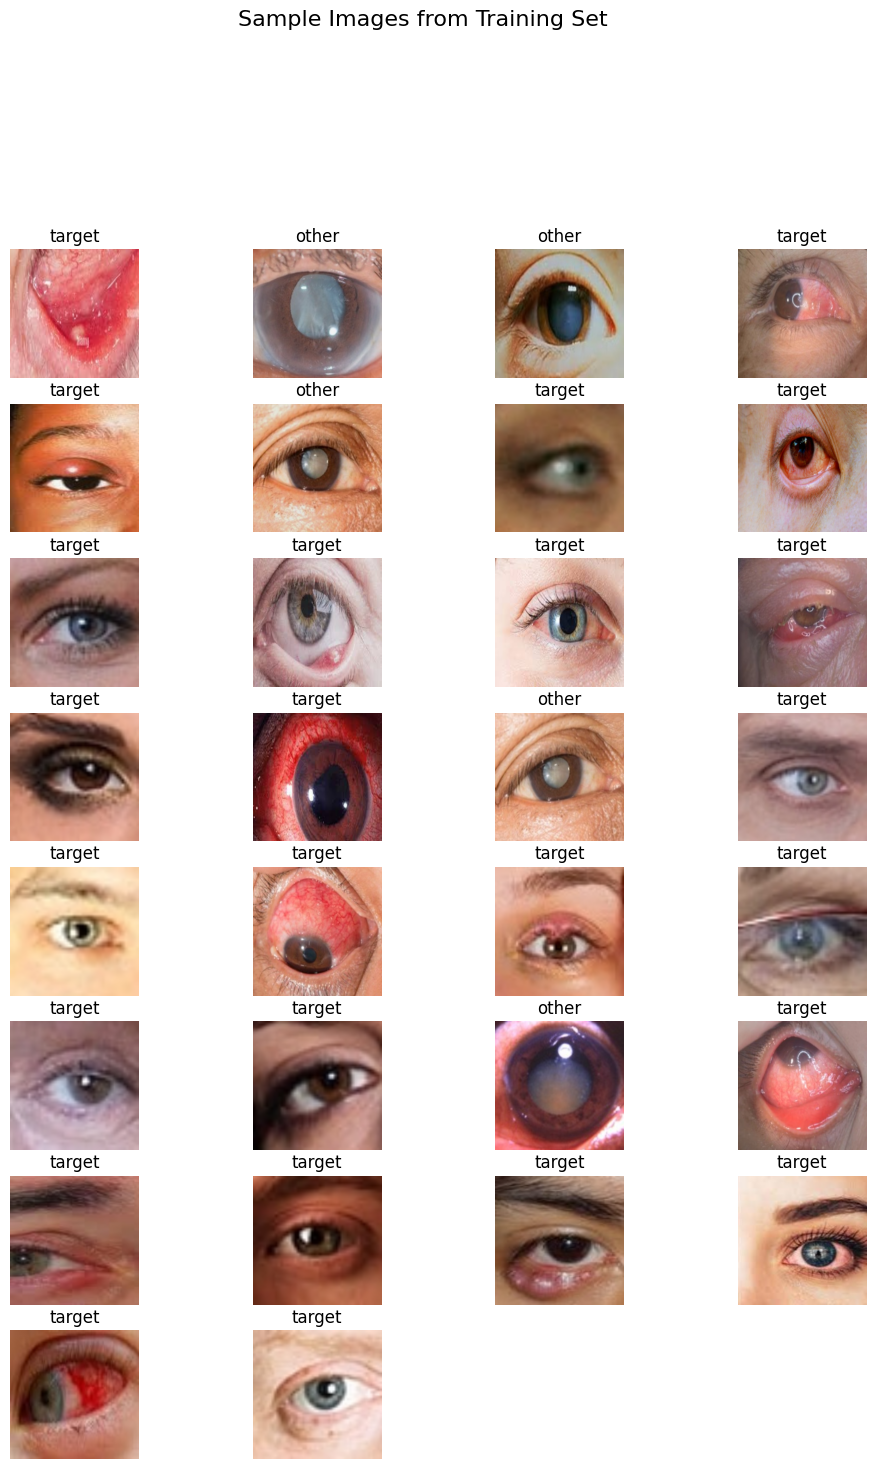

In [24]:
print(X_train, y_train, X_val, y_val, X_test, y_test)
print(class_names)
show_sample_images(X_train, y_train, ["target", "other"])


In [ ]:
# NEW--- One-vs-Rest (OvR) Training Loop ---
# This version includes class weights to handle data imbalance and a two-stage fine-tuning process.

INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

for class_name in class_names:
    print("\n" + "="*50)
    print(f"    Training Model for: {class_name} vs. Rest")
    print("="*50 + "\n")

    # 1. Create Binary Labels
    binary_labels = np.array([1 if label == class_name else 0 for label in labels])

    # 2. Split the Data
    (X_train_temp, X_test, y_train_temp, y_test) = train_test_split(
        images, binary_labels, test_size=0.20, stratify=binary_labels, random_state=42
    )
    (X_train, X_val, y_train, y_val) = train_test_split(
        X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp, random_state=42
    )
    print(f"Data split complete for '{class_name}'.")

    # --- THE FIX: CALCULATE CLASS WEIGHTS ---
    # This balances the loss function, forcing the model to pay attention to the minority class.
    weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight = {0: weights[0], 1: weights[1]}
    print(f"Class weights for '{class_name}': {class_weight}")

    # 3. Create and Compile the Model for Stage 1
    ovr_model = create_ovr_model()
    ovr_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # --- Stage 1: Initial Training (with Class Weights) ---
    print("\n--- Starting Stage 1: Initial Training ---")
    history = ovr_model.fit(
        X_train, y_train,
        epochs=INITIAL_EPOCHS,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        class_weight=class_weight,  # <--- Apply the class weights here
        verbose=2
    )

    # --- Stage 2: Fine-Tuning ---
    print("\n--- Starting Stage 2: Fine-Tuning ---")
    ovr_model.layers[0].trainable = True # Unfreeze the base model

    # Unfreeze the top 30 layers for fine-tuning
    for layer in ovr_model.layers[0].layers[:-30]:
        layer.trainable = False

    # Re-compile with a very low learning rate for fine-tuning
    ovr_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Continue training (fine-tuning)
    history_fine = ovr_model.fit(
        X_train, y_train,
        epochs=TOTAL_EPOCHS,
        initial_epoch=history.epoch[-1],
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        class_weight=class_weight, # <--- Also apply weights during fine-tuning
        verbose=2
    )

    # 4. Save and Evaluate the Final Model
    model_filename = f"efficientnet_ovr_{class_name}_finetuned.h5"
    ovr_model.save(model_filename)
    print(f"Model saved to {model_filename}")

    test_loss, test_acc = ovr_model.evaluate(X_test, y_test, verbose=0)
    print(f"\nFinal Test Accuracy for {class_name} vs. Rest: {test_acc:.2%}")

print("\nAll models have been trained and fine-tuned successfully!")


    Training Model for: Cataract vs. Rest

Data split complete for 'Cataract'.
Class weights for 'Cataract': {0: 0.6564299424184261, 1: 2.098159509202454}

--- Starting Stage 1: Initial Training ---
Epoch 1/10
43/43 - 17s - 390ms/step - accuracy: 0.4532 - loss: 0.7430 - val_accuracy: 0.7615 - val_loss: 0.6551
Epoch 2/10
43/43 - 13s - 292ms/step - accuracy: 0.4656 - loss: 0.7268 - val_accuracy: 0.2385 - val_loss: 0.6949
Epoch 3/10
43/43 - 13s - 292ms/step - accuracy: 0.5110 - loss: 0.7261 - val_accuracy: 0.7615 - val_loss: 0.6635
Epoch 4/10
43/43 - 13s - 312ms/step - accuracy: 0.5058 - loss: 0.7266 - val_accuracy: 0.7615 - val_loss: 0.6621
Epoch 5/10
43/43 - 13s - 307ms/step - accuracy: 0.5387 - loss: 0.7232 - val_accuracy: 0.2385 - val_loss: 0.7088
Epoch 6/10
43/43 - 13s - 305ms/step - accuracy: 0.4934 - loss: 0.7269 - val_accuracy: 0.2385 - val_loss: 0.7034
Epoch 7/10
43/43 - 14s - 321ms/step - accuracy: 0.4920 - loss: 0.7297 - val_accuracy: 0.7615 - val_loss: 0.6855
Epoch 8/10
43/43

In [ ]:

# --- Inference Section: Making a Prediction on a New Image ---

def predict_image_ovr(image_path, model_dir='.'):
    """
    Loads a new image, preprocesses it, and predicts its class
    using the saved One-vs-Rest models.
    """
    # 1. Load the trained OvR models
    ovr_models = {}
    for class_name in class_names:
        model_path = os.path.join(model_dir, f"efficientnet_ovr_{class_name}.h5")
        if os.path.exists(model_path):
            ovr_models[class_name] = tf.keras.models.load_model(model_path)
        else:
            print(f"Warning: Model not found for class '{class_name}' at {model_path}")
            return

    # 2. Load and preprocess the new image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0

    # 3. Get a prediction score from each binary classifier
    scores = {}
    for class_name, model in ovr_models.items():
        score = model.predict(img_array)[0][0]
        scores[class_name] = score

    # 4. Determine the final prediction
    # The class with the highest probability score is the winner.
    predicted_class = max(scores, key=scores.get)
    highest_score = scores[predicted_class]

    print("\n--- Prediction Results ---")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Condition: {predicted_class.capitalize()}")
    print(f"Confidence Score: {highest_score:.2%}")
    print("\n--- Individual Model Scores ---")
    for class_name, score in sorted(scores.items(), key=lambda item: item[1], reverse=True):
        print(f"- {class_name.capitalize()}: {score:.2%}")

# Example of how to use the prediction function
# Make sure you have an image to test with, for example 'test_image.jpg'
predict_image_ovr('/Users/aresbandebo/PycharmProjects/Eye_CNN_Testing/Dataset_Eye_Diseases_Classification/img_1.png')